# 6.6: Beyond Linearity Exercises

In [ ]:
!pip install ISLP

!pip install numpy==1.24.3

In [3]:
# Import our libraries and objects
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

# Load data
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

### Polynomial Regression

We'll use the `poly()` function to create a model matrix

In [4]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [6]:
# Create a grid of values for `age` at which we want predictions.
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

In [9]:
# Now we want to plot the data and add the fit from the fourth-degree polynomial
def plot_wage_fit(age_df, 
                  basis,
                  title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

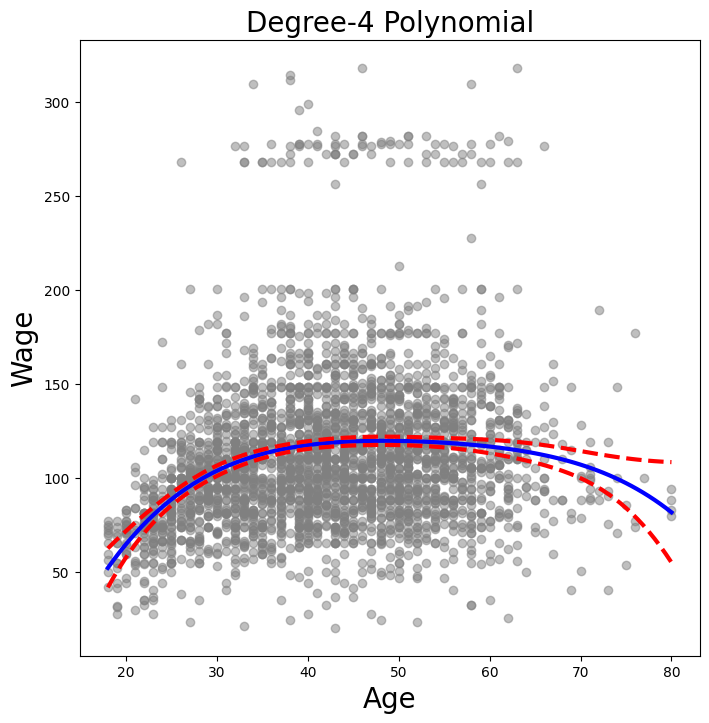

In [8]:
# Now we plot
plot_wage_fit(age_df, 
              poly_age,
              'Degree-4 Polynomial');

We now fit a series of models ranging from linear (degree-one) to degree-five polynomials, and look to determine the simplest model that is sufficient to explain the relationship between wage and age. We use the `anova_lm()` function, which performs a series of ANOVA tests.

In [10]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [11]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


Notice that the p-values are the same, and in fact the square of the t-statistics are equal to the F-statistics from the `anova_lm()` function

An alternative to the Anova method is to use cross-validation. 

**Describe the steps you would take to perform cross-validation in this case to choose the degree of the polynomial.**

### Step Function

We will now try to fit a step function to the data in order to again predict wage based on age.

In [12]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


The intercept coefficient can be interpreted as the average salary for individuals age < 34. The remaining
coefficients are the average additional salary for those in the other age groups.
**Make wage predictions for a range of ages and plot the results including the 95% confidence intervals.**

### Splines

We want to fit a regression spline with wage as the response and age as the predictor. In order to fit regression splines, we use transforms from the `ISLP` package.

In [18]:
# By default, the B-splines produced are cubic. To change the degree, use the argument degree
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [19]:
# We now fit a cubic spline model to the Wage data
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In order to fit a natural spline, we use the `NaturalSpline()` transform with the corresponding helper `ns()`. Here we fit a natural spline with five degrees of freedom (excluding the intercept) and plot the results.

In [22]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


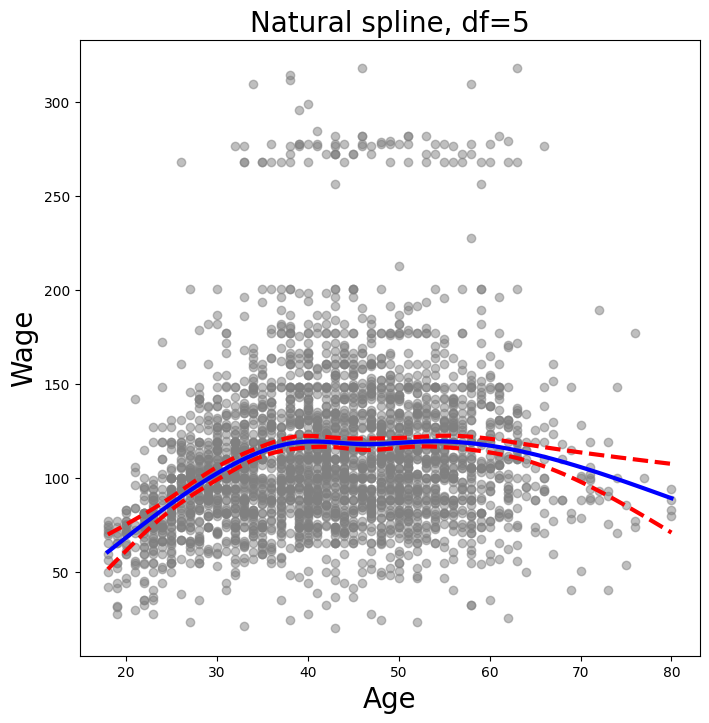

In [23]:
# Plot
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5');

### Local Regression

We illustrate the use of local regression using the `lowess()` function from `sm.nonparametric`.

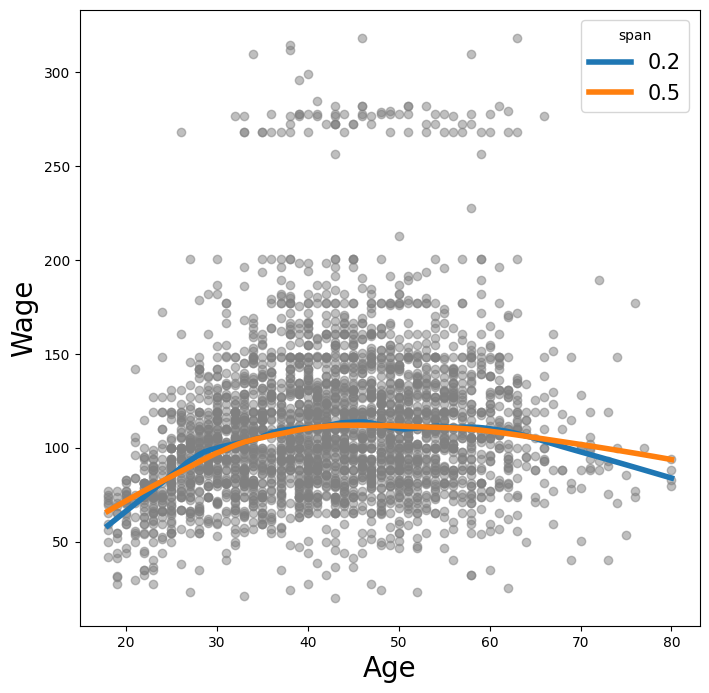

In [24]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);

**Redo the fitting and plotting but this time choose a smaller span. What differences do you
see? Explain why choosing a smaller span causes this.**

### Generalised Additive Models
We will fit a GAM to predict Wage using the predictors year, age, and education. The quantitative
predictors will be a natural spline functions and education will naturally be fit with a step function.

To fit GAMs in Python we will use the `pygam` package which can be installed via `pip install pygam`

In [25]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

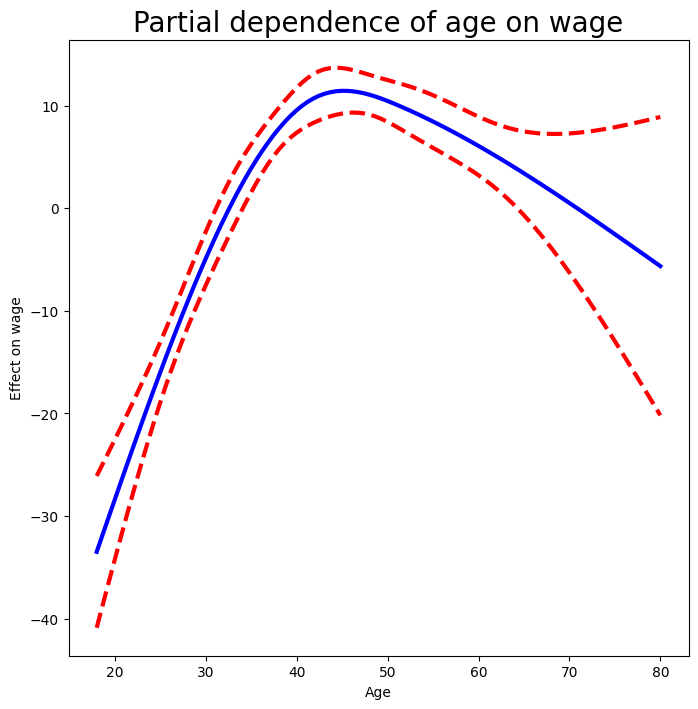

In [28]:
# Build model matrix
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

# Construct partial dependence plots
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

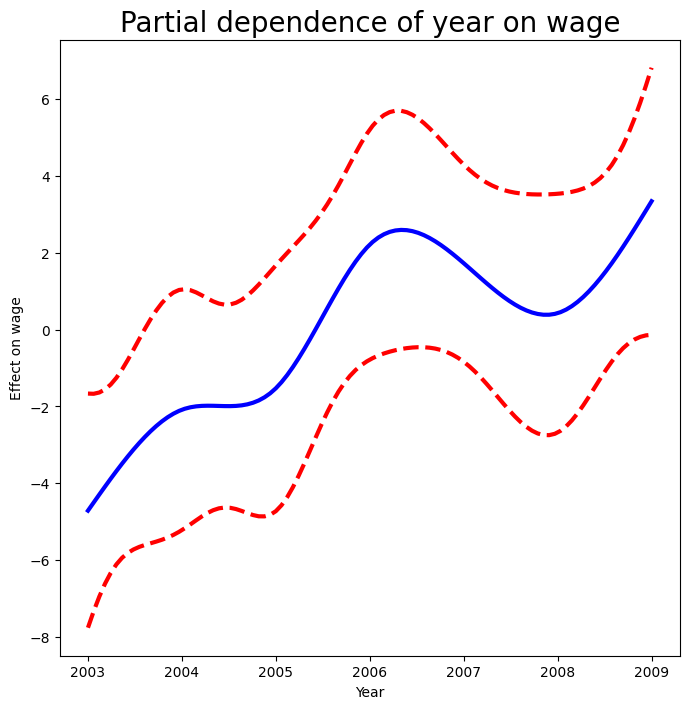

In [29]:
# Look at effect of year on wage
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

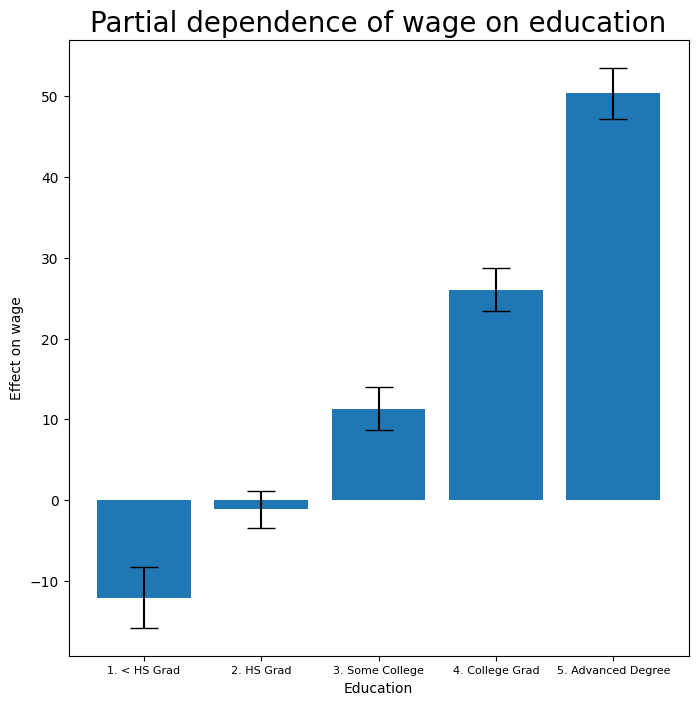

In [34]:
# Prepations
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

# Looking at education 
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

We can see from the plot that wage is increasing somewhat linearly with year. **Use an ANOVA test to
determine which of these three models is the best:**

- The same GAM as before except exclude year.
- The same GAM as before except it instead has a linear function of year (written simply + year)
- The GAM we have already fit.

**Recall that the models must be supplied to the anova() function in order of increasing complexity.
Once you have determined which model is the best, plot the relationships as we did before.**

To fit a logistic regression GAM, we use `LogisticGAM()` from pygam.

In [38]:
# Set up
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

# Logistic regression
gam_logit = LogisticGAM(age_term + 
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

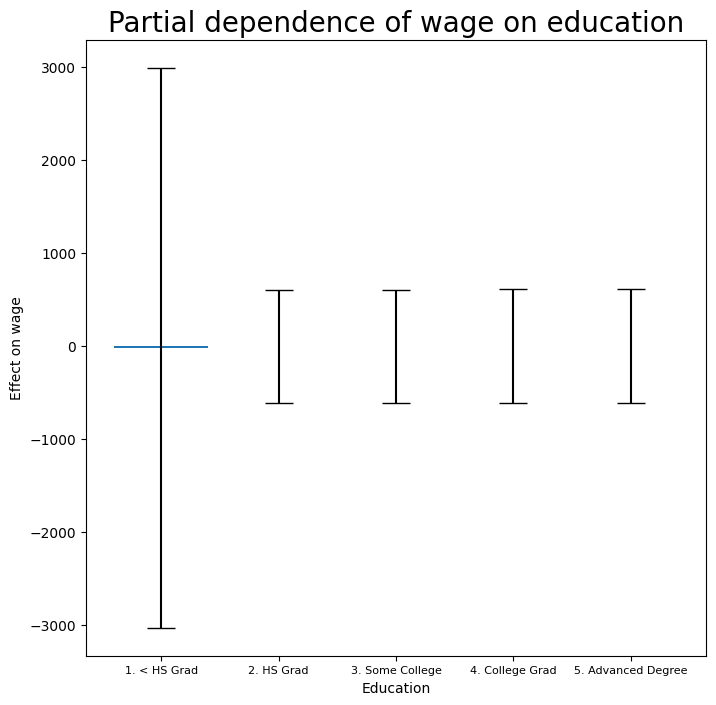

In [42]:
# Plot
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

The model seems to be very flat, with especially high error bars for the first category. Let's look at the data a bit more closely.


In [44]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


We see that there are no high earners in the first category of education, meaning that the model will have a hard time fitting. We will fit a logistic regression GAM excluding all observations falling into this category. This provides more sensible results.

In [48]:
# Prep / refit
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

# Now we fit the model
gam_logit_ = LogisticGAM(age_term +
                         year_term +
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

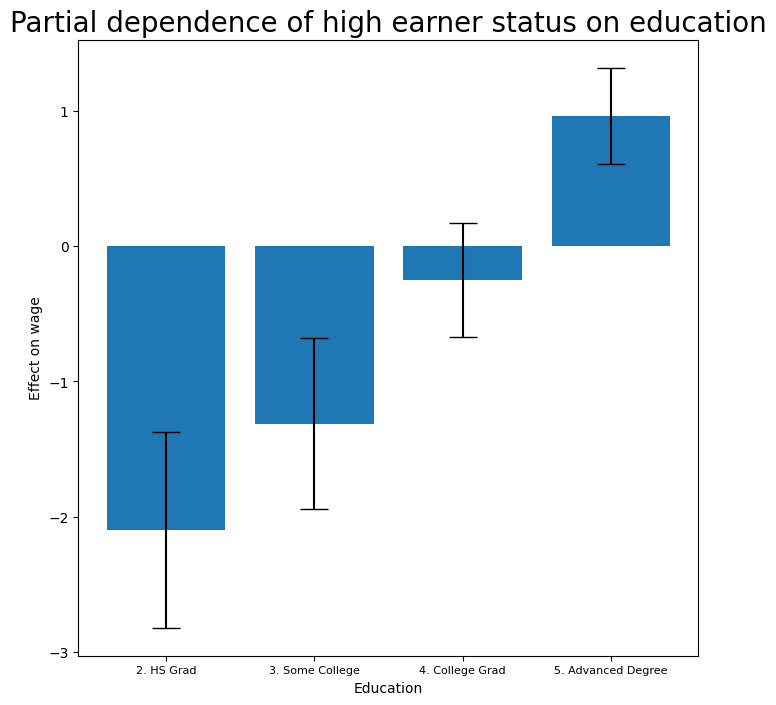

In [51]:
# Plot
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
                   fontsize=8);

*These exercises were adapted from :* James, Gareth, et al. An Introduction to Statistical Learning: with Applications in Python, Springer, 2023.